In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import pandas as pd
import seaborn as sns
from scipy import fft, fftpack
from matplotlib.colors import LogNorm
import dask.array as da
import dask.dataframe as ddf
import joypy
import cartopy.crs as ccrs
from skimage.transform import radon, resize

In [2]:
#open dataset
dm_tprime_xr_reanalysis = xr.open_dataset('/project2/geos39650/jet_stream/data/model_output/demean/demean_t_prime_1980_2020.nc4')
dm_tprime_xr_cmip = xr.open_dataset('/project2/geos39650/jet_stream/data/model_output/demean/demean_t_prime_cimp6_1980_2100.nc4')

## Hovmoller

In [3]:
def hovmoller(data,lat_range,dates,plot=True):
    data_strip = data.sel({'latitude': lat_range, 'time':dates})
    meaned_data_strip = data_strip.mean(dim=['latitude']).reset_coords('dayofyear',drop=True)
    #re-assign longitudes to make them more intuitive for people
    meaned_data_strip = meaned_data_strip.\
    assign_coords(longitude=(((meaned_data_strip.longitude + 180) % 360) - 180)).sortby('longitude')
    
    if 40.25 in data.latitude: #if its reanalysis instead of climate model output
        titlestr = r"$T'$ at Latitude $\sim 40 ^\circ$ in Winter %i for Reanalysis"%selected_dates[0].year
    else:
        titlestr = r"$T'$ at Latitude $\sim 40 ^\circ$ in Winter %i for CMIP6"%selected_dates[0].year
    hov_arry = meaned_data_strip.to_array()
    if plot:
        hov_arry.plot()#vmax=25
        plt.title(titlestr)
        plt.show()
    return hov_arry

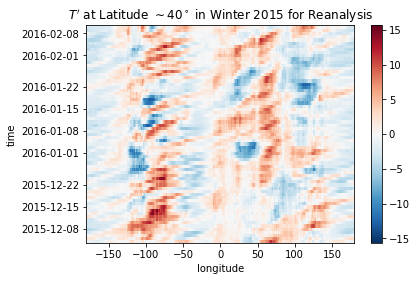

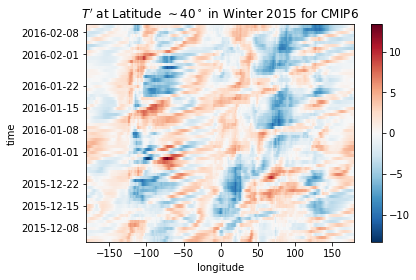

In [4]:
#some grooming
    #select only 10 weeks in the winter of 2016
weeks = 10
days = weeks*7-1
selected_dates= pd.date_range('2015-12-04',periods=days,freq='D')


#choose a latitude range where a lot of people live, like near chi-town
lat_range_reanalysis = np.arange(40,45.25,0.25)
lat_range_cmip = slice(40,45.25)

#and plot!

#compare reanalysis and climate output for the same date
hov_re = hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
hov_cesm = hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

#### A bunch of exploratory plots

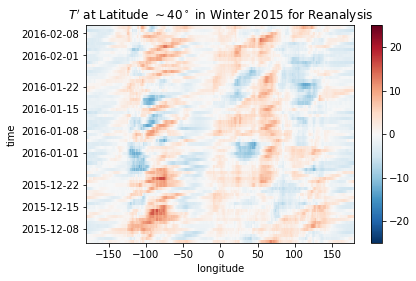

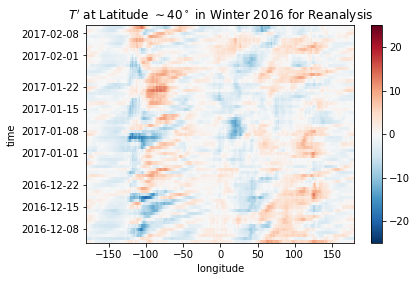

In [65]:
#two adjacent winters in reanalysis
selected_dates= pd.date_range('2015-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
selected_dates= pd.date_range('2016-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)

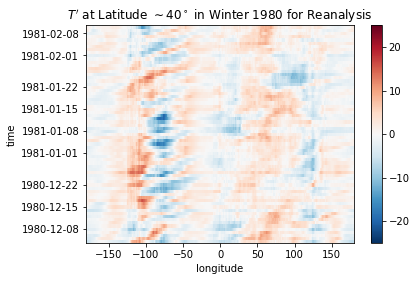

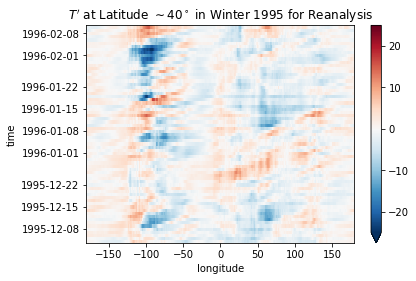

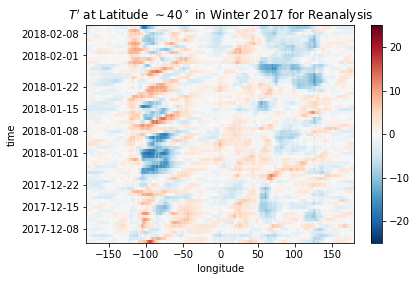

In [66]:
# now lets look at the difference between three winters in the past
selected_dates= pd.date_range('1980-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
selected_dates= pd.date_range('1995-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
selected_dates= pd.date_range('2017-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)

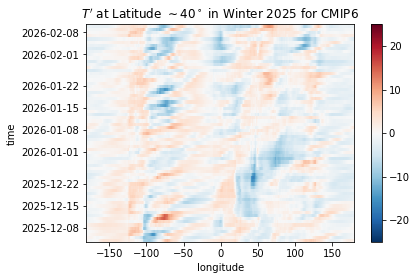

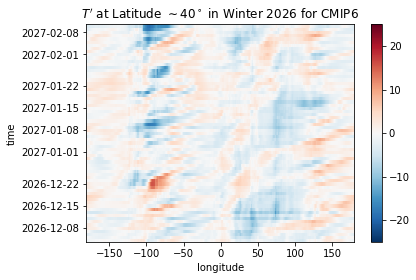

In [67]:
#two adjacent winters in climate model output
selected_dates= pd.date_range('2025-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)
selected_dates= pd.date_range('2026-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

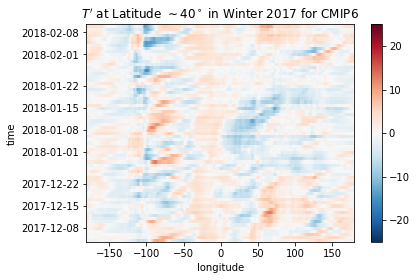

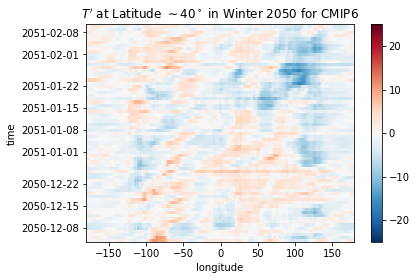

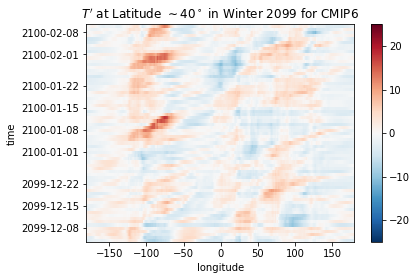

In [68]:
# difference between three winters in the future
selected_dates= pd.date_range('2017-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)
selected_dates= pd.date_range('2050-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)
selected_dates= pd.date_range('2099-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

seems like differences between decades look like the differences between 2 adjacent winters, at least by eye, for both reanalysis and climate model output

### Velocities from Hovmullers

#### Radon Transform

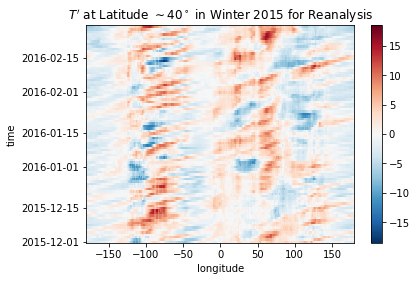

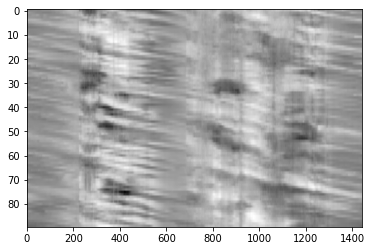

89.25


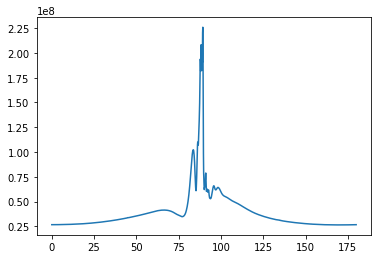

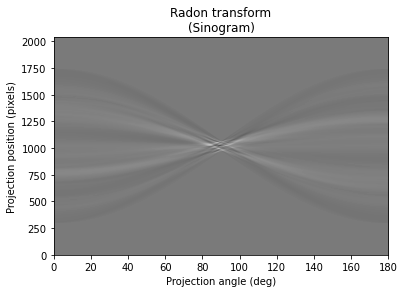

In [4]:
selected_dates= pd.date_range('2015-12-01','2016-02-28',freq='D')
                             #).union(pd.date_range('2016-12-01','2017-02-28',freq='D')
                              #      ).union(pd.date_range('2017-12-01','2018-02-28',freq='D')
                               #            ).union(pd.date_range('2014-12-01','2015-02-28',freq='D'))


#choose a latitude range where a lot of people live, like near chi-town
lat_range_reanalysis = np.arange(40,45.25,0.25)
lat_range_cmip = slice(40,45.25)

#compare reanalysis and climate output for the same date
hov_re = hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
# hov_cesm = hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

def vel_with_radon(hov_image):
    theta = np.linspace(0., 180., max(hov_image.shape), endpoint=False)
    sinogram = radon(hov_image, theta=theta,circle=False)
    sum_of_squares = np.sum(np.power(sinogram,2.),axis=0)
    print(theta[np.argmax(sum_of_squares)])
    plt.plot(theta,sum_of_squares)
    plt.show()
    return sum_of_squares,sinogram

# resized_hov_re = resize(hov_re.data[0,:], (hov_re.data[0,:].shape[0] , hov_re.data[0,:].shape[1] // 10),
#                        anti_alias1ing=True)

plt.imshow(hov_re.data[0,:],cmap=plt.cm.Greys_r, aspect='auto')
plt.show()

# plt.imshow(np.abs(resized_hov_re),cmap=plt.cm.Greys_r)
# plt.show()

rad_transf,sinogram = vel_with_radon(hov_re.data[0,:])
plt.title("Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

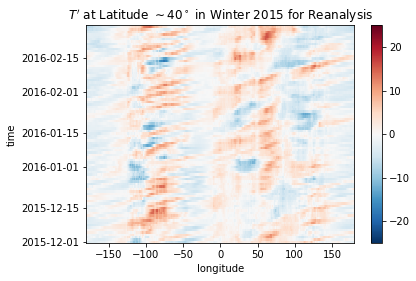

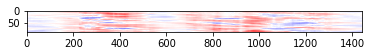

89.25


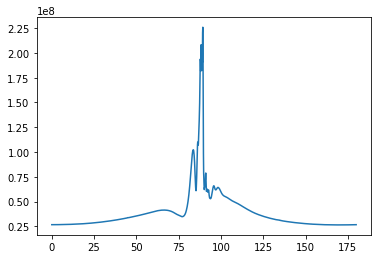

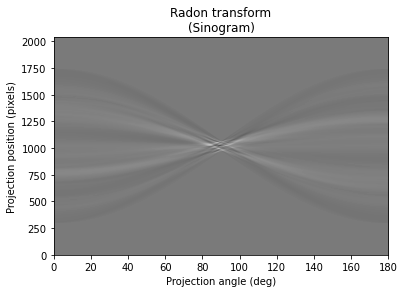

In [64]:
selected_dates= pd.date_range('2015-12-01','2016-02-28',freq='D')


#choose a latitude range where a lot of people live, like near chi-town
lat_range_reanalysis = np.arange(40,45.25,0.25)
lat_range_cmip = slice(40,45.25)

#and plot!

#compare reanalysis and climate output for the same date
hov_re = hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
# hov_cesm = hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

def vel_with_radon(hov_image):
    theta = np.linspace(0., 180., max(hov_image.shape), endpoint=False)
    sinogram = radon(hov_image, theta=theta,circle=False)
    sum_of_squares = np.sum(np.power(sinogram,2.),axis=0)
    print(theta[np.argmax(sum_of_squares)])
    plt.plot(theta,sum_of_squares)
    plt.show()
    return sum_of_squares,sinogram

# resized_hov_re = resize(hov_re.data[0,:], (hov_re.data[0,:].shape[0] , hov_re.data[0,:].shape[1] // 10),
#                        anti_aliasing=True)

plt.imshow(hov_re.data[0,:],cmap=plt.cm.bwr)
plt.show()

# plt.imshow(np.abs(resized_hov_re),cmap=plt.cm.Greys_r)
# plt.show()

rad_transf,sinogram = vel_with_radon(hov_re.data[0,:])
plt.title("Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

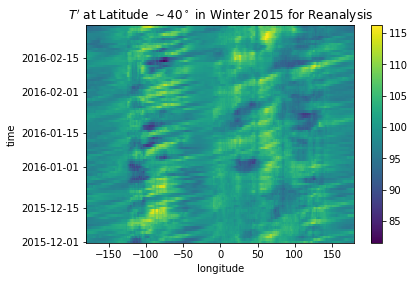

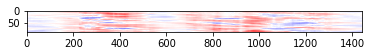

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


0.0


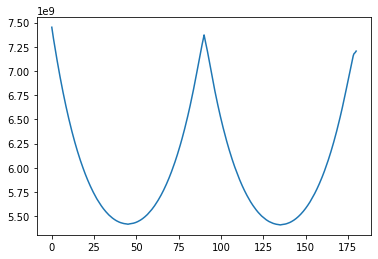

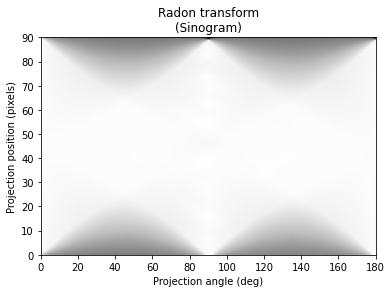

In [70]:
selected_dates= pd.date_range('2015-12-01','2016-02-28',freq='D')


#choose a latitude range where a lot of people live, like near chi-town
lat_range_reanalysis = np.arange(40,45.25,0.25)
lat_range_cmip = slice(40,45.25)

#and plot!

#compare reanalysis and climate output for the same date
hov_re = hovmoller(dm_tprime_xr_reanalysis+100,lat_range_reanalysis,selected_dates)
# hov_cesm = hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

def vel_with_radon(hov_image):
    theta = np.linspace(0., 180., max(hov_image.shape), endpoint=False)
    sinogram = radon(hov_image, theta=theta,circle=True)
    sum_of_squares = np.sum(np.power(sinogram,2.),axis=0)
    print(theta[np.argmax(sum_of_squares)])
    plt.plot(theta,sum_of_squares)
    plt.show()
    return sum_of_squares,sinogram

# resized_hov_re = resize(hov_re.data[0,:], (hov_re.data[0,:].shape[0] , hov_re.data[0,:].shape[1] // 10),
#                        anti_aliasing=True)

plt.imshow(hov_re.data[0,:],cmap=plt.cm.bwr)
plt.show()

# plt.imshow(np.abs(resized_hov_re),cmap=plt.cm.Greys_r)
# plt.show()

rad_transf,sinogram = vel_with_radon(hov_re.data[0,:])
plt.title("Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

In [19]:
hov_re.data[0,:].shape

(69, 1440)

#### Fourier Transform

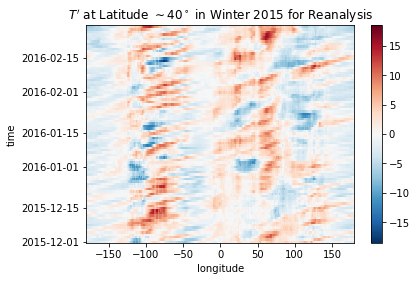

In [40]:
selected_dates= pd.date_range('2015-12-01','2016-02-28',freq='D')
#                              ).union(pd.date_range('2016-12-01','2017-02-28',freq='D')
#                                    ).union(pd.date_range('2017-12-01','2018-02-28',freq='D')
#                                            ).union(pd.date_range('2014-12-01','2015-02-28',freq='D'))


#choose a latitude range where a lot of people live, like near chi-town
lat_range_reanalysis = np.arange(40,45.25,0.25)
lat_range_cmip = slice(40,45.25)

#compare reanalysis and climate output for the same date
hov_re = hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)

In [41]:
#1D

#over time
#add multiple years together
numyears=10
ffts = np.zeros((numyears,len( pd.date_range('2015-12-01','2016-02-28',freq='D'))))
for i in range(numyears):
    selected_dates= pd.date_range(str(1990+i)+'-12-01',str(1991+i)+'-02-28',freq='D')
    hov = hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
    x = hov.sel(longitude=-100)[0,:]
    y = fft(x)
    peak_wavenumber=np.argmax(y)
    plt.plot(np.arange(90),x,linewidth = 4)
    plt.plot(np.arange(90),y[peak_wavenumber]/90. * np.exp(2*np.pi*peak_wavenumber*1.j*np.arange(90)/90.),label=str(i))
    plt.show()
    ffts[i] = y

total_time_fft = np.sum(ffts,axis=0)
plt.plot(total_time_fft)
plt.show()


# xf_time =fftpack.fftfreq(len(hov_re.time),1.)
# xf_time = fftpack.fftshift(xf_time)
# yplot =fftpack.fftshift(oneD_fft_time)
# plt.plot(xf_time,np.abs(yplot),linewidth=0.5)
# omega_max = xf_time[np.argmax(np.abs(yplot))]
# print(omega_max, 1/omega_max)
# plt.axvline(omega_max, color='k')
# plt.show()

# plt.plot(np.arange(len(hov_re.time)),hov_re.sel(longitude=-100)[0,:])
# plt.plot(np.arange(len(hov_re.time)),np.sin(np.arange(len(hov_re.time))*omega_max))
# plt.show()

NameError: name 'oneD_fft_time' is not defined

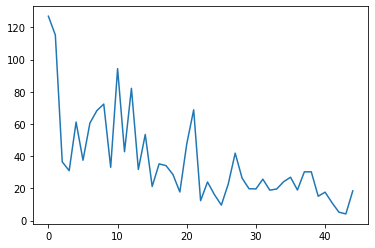

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


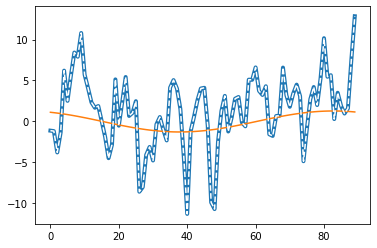

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


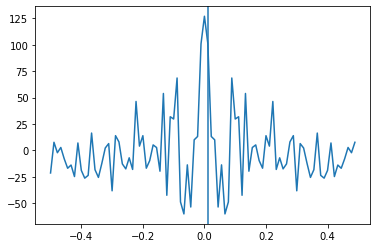

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


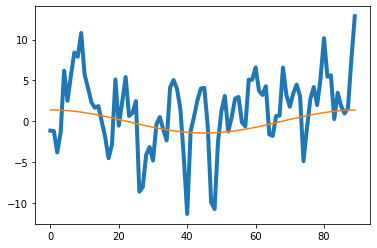

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


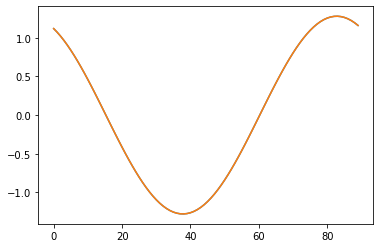

In [51]:
x=hov_re.sel(longitude=-100)[0,:]
y = fft(x)
plt.plot((np.abs(y[:len(y)//2])))
# plt.xlim(0,20)
plt.show()
plt.plot(np.arange(len(hov_re.time)),x,linewidth = 4)

plt.plot(np.arange(len(hov_re.time)),y[1]/len(x) * np.exp(2*np.pi*1.j*np.arange(len(x))/len(x))) #factor of 2pi helps but doesn't fix it completely

from scipy import ifft
yinv = ifft(y)
plt.plot(np.arange(len(hov_re.time)),yinv,linestyle='--',color='white')
plt.show()

y_shift = fftpack.fftshift(y)
xf = fftpack.fftfreq(len(x),1)
xf_shift = fftpack.fftshift(xf)
plt.plot(xf_shift,y_shift)
arg_to_pick_out = len(xf_shift)//2+1
max_freq = xf_shift[arg_to_pick_out]
plt.axvline(max_freq)
plt.show()


plt.plot(np.arange(len(hov_re.time)),x,linewidth = 4)
plt.plot(np.arange(len(hov_re.time)),np.max(y_shift)/len(xf) * np.exp(2*np.pi*max_freq*1.j*np.arange(len(hov_re.time))))
plt.show()

plt.plot(np.arange(len(hov_re.time)),y_shift[arg_to_pick_out]/len(xf) * np.exp(2*np.pi*max_freq*1.j*np.arange(len(hov_re.time))))
plt.plot(np.arange(len(hov_re.time)),y[1]/len(x) * np.exp(2*np.pi*1.j*np.arange(len(x))/len(x))) #factor of 2pi helps but doesn't fix it completely
plt.show()

#so output frequencies are not angular

-0.002777777777777778 -360.0


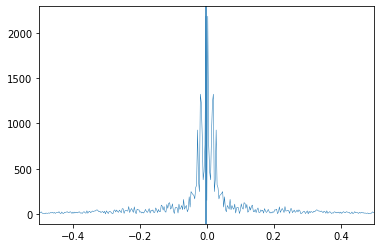

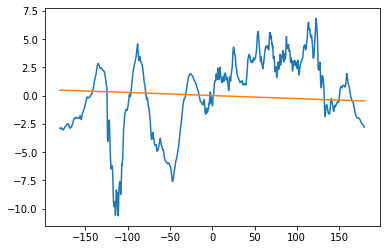

In [111]:
#over longitude
hov_on_continent = hov_re.sel({'time':'2015-12-01'})#,'longitude':slice(-124.25,-68)})
oneD_fft_long =fftpack.fft(hov_on_continent[0,:])
xf = fftpack.fftfreq(len(hov_on_continent.longitude), 0.25)
xf_long = fftpack.fftshift(xf)
yplot_long =fftpack.fftshift(oneD_fft_long)
plt.plot(xf_long,np.abs(yplot_long),linewidth=0.5)
plt.xlim(-0.5,0.5)
# plt.yscale('log')
k_max = xf_long[np.argmax(np.abs(yplot_long))]
print(k_max, 1/k_max)
plt.axvline(k_max)
plt.show()

# plt.plot(xf_long,np.abs(yplot_long),linewidth=0.5)
# plt.plot(xf_time,np.abs(yplot),linewidth=0.5)
# plt.xlim(-0.2,0.2)
# plt.show()

plt.plot(hov_on_continent.longitude,hov_on_continent[0,:])
plt.plot(hov_on_continent.longitude,np.sin(hov_on_continent.longitude*k_max)) #factor of 2pi helps but doesn't fix it completely
plt.show()

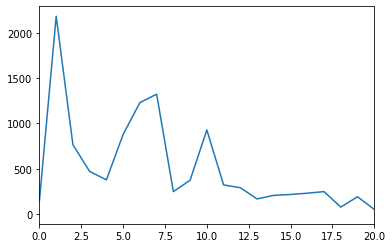

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


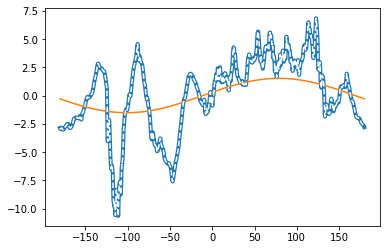

In [112]:
#check to see what helper functions are actually doing and see if the peak is actaully where im saying it is
x=hov_on_continent[0,:]
y = fft(x)
plt.plot((np.abs(y[:len(y)//2])))
plt.xlim(0,20)
plt.show()
plt.plot(hov_on_continent.longitude,x,linewidth = 4)
plt.plot(hov_on_continent.longitude,y[1]/len(x) * np.exp(2*np.pi*1.j*np.arange(len(x))/len(x))) #factor of 2pi helps but doesn't fix it completely
from scipy import ifft
yinv = ifft(y)
plt.plot(hov_on_continent.longitude,yinv,linestyle='--',color='white')
plt.show()


In [143]:
velocity = 4.6 * np.cos(40. * np.pi/180.) * omega_max / (2.*np.pi * k_max)
velocity

3.9258162639649283

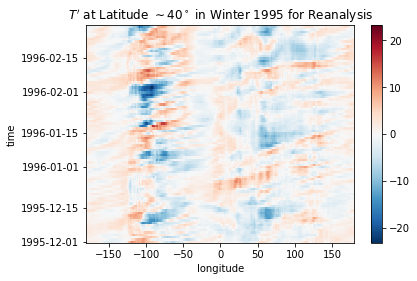

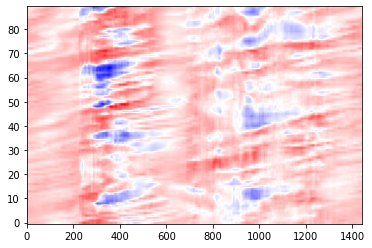

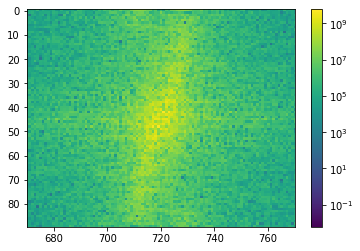

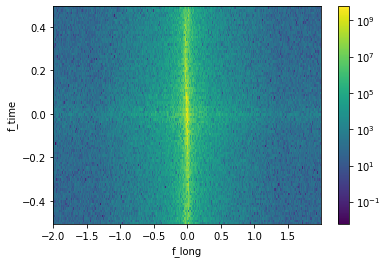

In [105]:
# #2D
selected_dates= pd.date_range('1995-12-01','1996-02-28',freq='D')
#                              ).union(pd.date_range('2016-12-01','2017-02-28',freq='D')
#                                     ).union(pd.date_range('2017-12-01','2018-02-28',freq='D')
#                                            ).union(pd.date_range('2014-12-01','2015-02-28',freq='D'))
lat_range_reanalysis = np.arange(40,45.25,0.25)

hov_re = hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
plt.imshow(hov_re[0,:],cmap='bwr',aspect='auto',origin='lower')
plt.show()

im_fft = fftpack.fft2(hov_re.data[0,:])
shifted_squared = np.abs(fftpack.fftshift(im_fft))**2
plt.imshow(shifted_squared,
           aspect='auto',
           interpolation='none',norm=LogNorm())
plt.colorbar()
plt.xlim(720-50,720+50)
# plt.ylim(35,55)
plt.show()

xf_long = fftpack.fftfreq(len(hov_re.longitude), 0.25)
xf_long = fftpack.fftshift(xf_long)

yf_time = fftpack.fftfreq(len(hov_re.time),1.)
yf_time = fftpack.fftshift(yf_time)

fft2d_xr = xr.DataArray(shifted_squared,
                       dims=('f_time','f_long'), coords=(yf_time,xf_long))
fft2d_xr.plot(norm=LogNorm())

# plt.imshow(np.abs(fftpack.fftshift(im_fft)**2),
#            aspect='auto',norm=LogNorm(),extent=(xf_long[0],xf_long[-1],yf_time[0],yf_time[-1])
#           )
#do helper functions to get axes
# plt.colorbar()
plt.show()
# np.abs(im_fft)

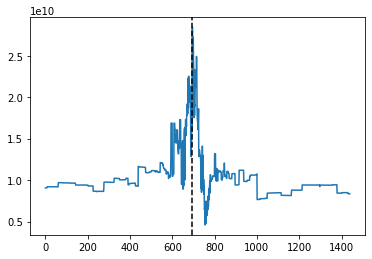

-1.816326530612245


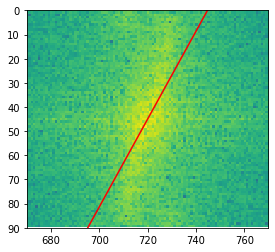

In [106]:
x_axis_len = len(shifted_squared[0])
integrated_power = np.zeros(x_axis_len)
slopes = np.zeros(x_axis_len)
for ix in range(x_axis_len) :
#     for iy, y in enumerate(shifted_squared[:,0]) :
    #define line to extract data along
    x0, y0 = ix, 89 # These are in _pixel_ coordinates!!
    x1, y1 = x_axis_len-ix-1, 0
    length = int(np.hypot(x1-x0, y1-y0))
    x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)
    
    #save slope (pixels are in units of wavenumber)
    slopes[ix] = (y1-y0)/(x1-x0)

    # Extract the values along the line
    zi = shifted_squared.T[x.astype(np.int), y.astype(np.int)]
    integrated_power[ix] = np.sum(zi) #dx =1 since this is pixels
    
#     if ix%100==0:
#         #-- Plot...
#         fig, axes = plt.subplots(nrows=2)
#         axes[0].imshow(shifted_squared,interpolation='none',norm=LogNorm())
#         axes[0].plot([x0, x1], [y0, y1], 'r-')
#         axes[0].axis('image')
#         axes[0].set_xlim(720-50,720+50)

#         axes[1].plot(zi)

#         plt.show()
y_axis_len = 90
# integrated_power_2 = np.zeros(y_axis_len)

plt.plot(integrated_power)
# plt.plot(np.arange(x_axis_len,x_axis_len+y_axis_len),integrated_power_2)
max_idx = np.argmax(integrated_power)
plt.axvline(max_idx,color='k',linestyle='--')
plt.show()

#make line
slope_max = slopes[max_idx]
x = np.linspace(0,1440)
y = slope_max*(x- 720) + 45 
# y = 25.2*(x- 720) + 45 
print(slope_max) #velociy in (1/day / (1/.25 deg longitude))
plt.imshow(shifted_squared,interpolation='none',norm=LogNorm())

plt.plot(x,y, 'r-')
plt.xlim(720-50,720+50)
plt.ylim(90,0)
plt.show()

In [64]:
lat = np.mean(lat_range_reanalysis)*np.pi/180.
delta_sigma = np.arccos(np.sin(lat)*np.sin(lat) + np.cos(lat)*np.cos(lat)*np.cos(0.25*np.pi/180.))
print (delta_sigma)
dist = 6371 * delta_sigma
print(dist)

slope_max*dist/(3600*24.)

0.0032169780921868043
20.49536742532213


-0.00043085971769975186

-2.282051282051282

-1.816326530612245


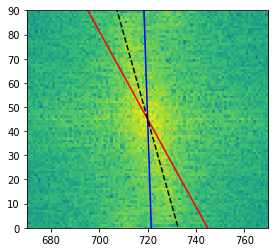

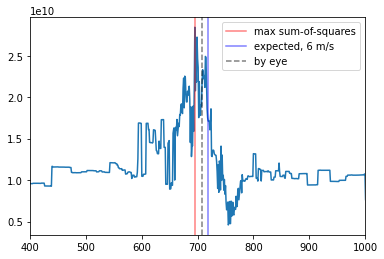

In [127]:
expected_idx = max_idx+23
alt_idx = max_idx+12
slope_min = slopes[np.argmin(integrated_power)]
slope_max = slopes[max_idx]
slope_alt = slopes[alt_idx]
slope_expected = slopes[expected_idx]
x = np.linspace(0,1440)
y = slope_max*(x- 720) + 45 
y_expeced = slope_expected*(x- 720) + 45 
y_min = slope_min*(x- 720) + 45
y_alt = slope_alt*(x- 720) + 45
print(slope_max) #velociy in (1/day / (1/.25 deg longitude))
plt.imshow(shifted_squared,interpolation='none',norm=LogNorm())
plt.plot(x,y, 'r-')
plt.plot(x,y_expeced,'b-')
# plt.plot(x,y_min,'r--')
plt.plot(x,y_alt,'k--')
plt.xlim(720-50,720+50)
plt.ylim(0,90)
plt.show()

plt.plot(integrated_power)
# plt.plot(np.arange(x_axis_len,x_axis_len+y_axis_len),integrated_power_2)
max_idx = np.argmax(integrated_power)
plt.axvline(max_idx,color='r',alpha=0.5,label='max sum-of-squares')
plt.axvline(expected_idx,color='b',alpha=0.5,label='expected, 6 m/s')
plt.axvline(alt_idx,color='k',linestyle='--',alpha=0.5,label='by eye')
plt.legend()
plt.xlim(400,1000)
plt.show()

In [128]:
slope_alt*dist/(3600*24.)

-0.0008444850466915137

In [85]:
numyears=25
velocities = np.zeros(numyears)
#these will get overwritten
integrated_power = np.zeros(x_axis_len)
slopes = np.zeros(x_axis_len)

for yr in range(numyears):
    selected_dates= pd.date_range(str(1980+yr)+'-12-01',str(1981+yr)+'-02-28',freq='D')
    hov = hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates,plot=False)
    
    im_fft = fftpack.fft2(hov.data[0,:])
    shifted_squared = np.abs(fftpack.fftshift(im_fft))**2
    
    for ix in range(x_axis_len) :
        #define line to extract data along
        x0, y0 = ix, 89 # These are in _pixel_ coordinates!!
        x1, y1 = x_axis_len-ix-1, 0
        length = int(np.hypot(x1-x0, y1-y0))
        x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

        #save slope (pixels are in units of wavenumber)
        slopes[ix] = -1*(y1-y0)/(x1-x0)

        # Extract the values along the line
        zi = shifted_squared.T[x.astype(np.int), y.astype(np.int)]
        integrated_power[ix] = np.sum(zi) #dx =1 since this is pixels
    max_idx = np.argmax(integrated_power)
    slope_max = slopes[max_idx]
    velocities[yr] = slope_max*dist/(3600*24.)

In [96]:
0.006/(dist/(3600*24.))

25.293520688949165

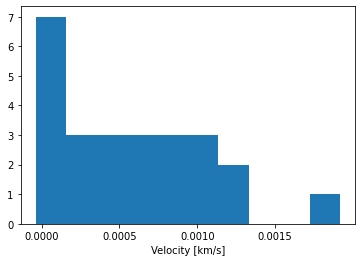

0.0005786443100917939


In [94]:
plt.hist(velocities,bins=10)
plt.xticks(np.arange(0,2e-3,5e-4))
plt.xlabel('Velocity [km/s]')
plt.show()
print(np.mean(velocities))


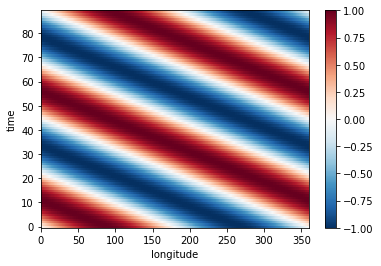

(2, 1)
(1, 1)


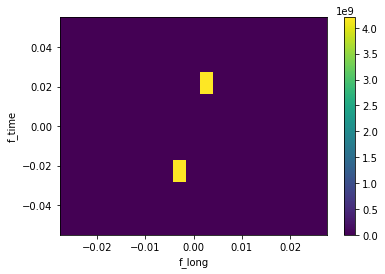

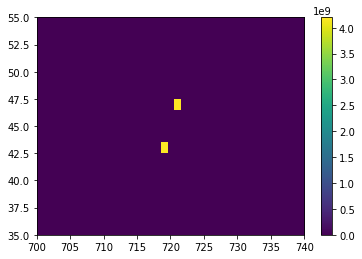

In [38]:
grid = np.meshgrid(np.arange(1440)*0.25,np.arange(90))
global_wave = np.sin(1*np.radians(grid[0])+ 2*np.pi*2 * grid[1]/90.) #+ np.sin(2*np.pi*6 * grid[1]/90.)
globe_xr = xr.DataArray(global_wave,
                       dims={'time','longitude'},
                        coords={'time':np.arange(90),'longitude':np.arange(1440)*0.25})
globe_xr.plot()
plt.show()

FT = fftpack.fftn(globe_xr.data)
idx = np.unravel_index(np.abs(FT[:,:]).argmax(),FT.shape)
# idx = np.where(np.abs(FT)!=0)
print(idx)
idx = np.unravel_index(np.abs(FT[1:,:]).argmax(),FT.shape)
# idx = np.where(np.abs(FT)!=0)
print(idx)

xf = fftpack.fftfreq(len(globe_xr.longitude), 0.25)
xf = fftpack.fftshift(xf)

yf = fftpack.fftfreq(len(globe_xr.time),1.)
yf = fftpack.fftshift(yf)

FT_xr = xr.DataArray(np.abs(fftpack.fftshift(FT))**2,
                       dims=('f_time','f_long'), coords=(yf,xf))
FT_xr.plot()
plt.xlim(-0.0277,0.0277)
plt.ylim(-0.055,0.055)
plt.show()

FT_xr.isel(f_time=FT_xr.argmax(dim='f_time')).argmax()
plt.imshow((np.abs(fftpack.fftshift(FT))**2),aspect='auto',interpolation='none')
plt.colorbar()
plt.xlim(700,740)
plt.ylim(35,55)
plt.show()
# plt.scatter(FT_xr.isel(f_time=FT_xr.argmax(dim='f_time')).argmax(),FT_xr.argmax(dim='f_time')[0])

In [35]:
10/90 *0.5

0.027777777777777776

(0, 10)


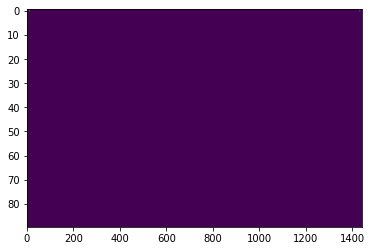

In [139]:
idx = np.unravel_index(np.abs(FT[:,:]).argmax(),FT.shape)
print(idx)
plt.imshow(np.abs(FT),aspect='auto')

## Joy division

In [5]:
def group_into_winters(dates): #untested
    year_arr = np.zeros(len(dates),dtype=int)
    y=0
    for date in dates:
        if date.month < 3:
            year_arr[y] = date.year - 1
        else:
            year_arr[y] = date.year
        y+=1
    return year_arr

def joy_div(data,data_key='t_prime',decade=False):
    ''' accepts a dataframe and make a joy division plot of successive distributions in data_key. 
     If decade=False, these distributions are calculated yearly. If True, they are calculated every 10 years'''
            
    data['year'] = group_into_winters(data.index)
    time_key='year'
    if decade:
        time_key='decade'
        data['decade'] = data.year.apply(lambda x: int(x)//10 * 10)
    data_filter = data.filter([time_key,data_key])
    
    labels=[y if y%5==0 else None for y in list(data[time_key].unique())]
    fig, axes = joypy.joyplot(data_df_chi, 
                          by=time_key,
                              labels=labels,
                              grid='y',
                              linewidth=1,
                          column=data_key,
                          fade=True,
                          figsize=(10,10))
    plt.xlabel("T' [K]")
    plt.xlim(-20,20)
    plt.ylabel("year")
    plt.show()
    return data_filter

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home

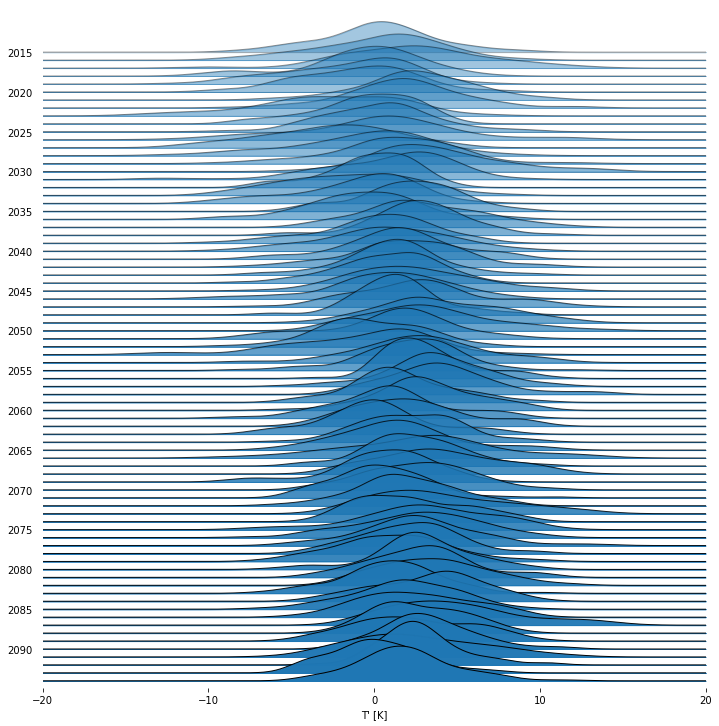

,year,t_prime
time,,
2015-12-01,2015,-1.053966
2015-12-02,2015,-1.140511
2015-12-03,2015,-2.459364
2015-12-04,2015,-1.891411
2015-12-05,2015,-1.664401
...,...,...
2095-02-24,2094,0.975421
2095-02-25,2094,6.024979
2095-02-26,2094,11.295614


In [7]:
# dm_lateff_reanalysis = xr.open_dataset('/project2/geos39650/jet_stream/data/model_output/eff_lat/eff_lat_reanalysis_1980_2018.csv')

#choose a location
data_xr_chi = dm_tprime_xr_cmip.sel({'longitude': 272.5, 'latitude':42.0},method='nearest')
#now get rid of those extraeous location coords
data_xr_chi=data_xr_chi.reset_coords(['longitude', 'latitude'],drop=True)

#make it a dataframe for easier handling with joypy
data_df_chi = data_xr_chi.to_dataframe()
joy_div(data_df_chi)

## Overlayed KDEs

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home

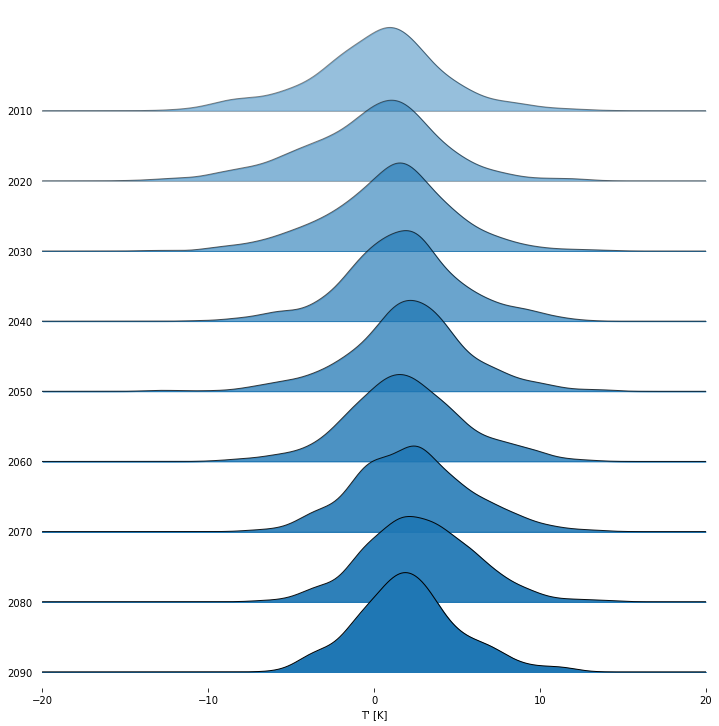

In [8]:
decadal_data = joy_div(data_df_chi,data_key='t_prime',decade=True)

In [7]:
def overlayed_decades(data,year,axis,clr='blue'):
    data_in_decade = data.loc[(data['decade']==year),'t_prime']
    sns.kdeplot(data_in_decade, ax=axis, shade=True, alpha=0.3, Label=str(year)+'s',color=clr)
    quantiles = np.quantile(data_in_decade,[0.1,0.9])
    plt.axvline(quantiles[0],color=clr,linestyle='--',alpha=0.5)
    plt.axvline(quantiles[1],color=clr,linestyle='--',alpha=0.5)

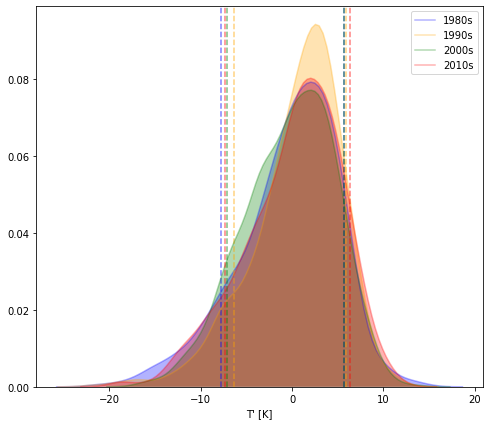

In [9]:
fig, ax = plt.subplots(figsize=(8, 7))
overlayed_decades(decadal_data,1980,ax,'blue')
overlayed_decades(decadal_data,1990,ax,'orange')
overlayed_decades(decadal_data,2000,ax,'green')
overlayed_decades(decadal_data,2010,ax,'red')
plt.xlabel("T' [K]")
plt.show()

### Plot Skewness over Time

In [54]:
def globe_plots(xarr,titlestr="",contour=False,contours=None,savetitle=None):
    #set up the axes for a globe
    plt.subplots(figsize = (10, 10))
    ax = plt.axes(projection=ccrs.Orthographic(20, 90))
    #coolcool now we can plot it
    
    if contour:
        if contours is None:
            contours=range(int(xarr.min()),int(xarr.max()),10)
        xarr.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=contours,
                           center=0,
                           cbar_kwargs={'orientation': 'horizontal',
                                    'pad': 0.05,
                                    'shrink': 0.5,
                                    'ticks':contours}
                                       )
    else:
        xarr.plot(ax=ax, transform=ccrs.PlateCarree())
        
    ax.set_title(titlestr)
    #make it draw the pretty continents
    ax.set_global(); ax.coastlines();
    #draw lat-lon isocontours
    ax.gridlines()
    ax.plot()
    if savetitle is None:
        plt.show()
    else:
        plt.savefig('./figs/'+savetitle+'.png')
        
def convert_to_xarray(sequence,plot=False,contour=False, contours=None, 
                      titlestr=r"$T'(\phi,\lambda) =  T(\phi,\lambda) - T_{ref}(\phi) $", savetitle = None,
                      numweeks=1,data_source='reanalysis'
                     ):
    """this assumes a very specific structure to the sequence 
    (0.25 deg resolution on regular grid, latitudes only above 20 deg)
    that probably only works for the specific data array I am using in this notebook.
    Note that if numweeks !=1, plotting probably won't work as planned.
    """
    #hard code my coords because I'm only going to use this
    if data_source == 'reanalysis':
        latitude_coords = np.flip(np.arange(20.25,90.001,step=0.25))
        longitude_coords = np.arange(0,360,step=0.25)
        shape = (280,1440)        
    elif data_source == 'CESM':
        latitude_coords = np.flip(np.arange(20.2617801,90.001,step=0.94240838))
        longitude_coords = np.arange(0,360,step=1.25)
        shape = (len(latitude_coords),len(longitude_coords))
    else:
        print('not a regognized data source!')
        return np.nan
    if numweeks == 1:
        d = ('lat','lon')
        c = {'lat':latitude_coords,'lon':longitude_coords}
        z = np.array(sequence).reshape(shape)
        print('one week!')
    else:
        d = ('time','lat','lon')
        time_coords = range(numweeks)
        c = {'time': time_coords,'lat':latitude_coords,'lon':longitude_coords}
        z = np.array(sequence).reshape((numweeks,280,1440))
    xarr = xr.DataArray(z,
                       dims = d,
                       coords = c)
    if plot:
        globe_plots(xarr,titlestr,contour=contour,contours=contours,savetitle=savetitle)
    
    return xarr

In [55]:
skew_xr = xr.Dataset(pd.read_csv('/project2/geos39650/jet_stream/data/model_output/eff_lat/skewnessoutput.csv'))
# skew_xr = skew_xr.reset_index(['latitude','longitude'])
skew_xr = skew_xr.reset_index('Unnamed: 0',drop=True)

one week!


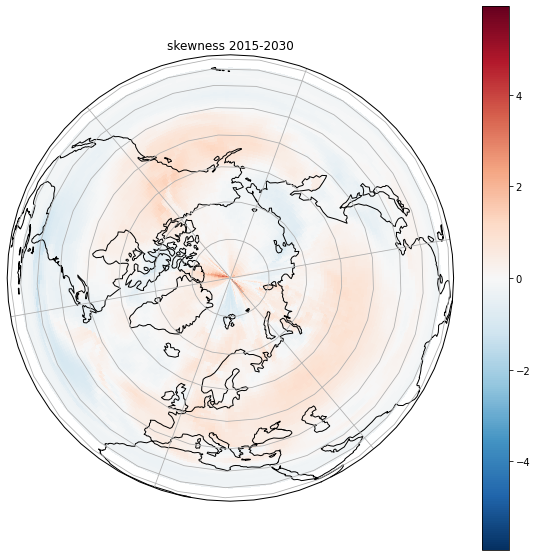

one week!


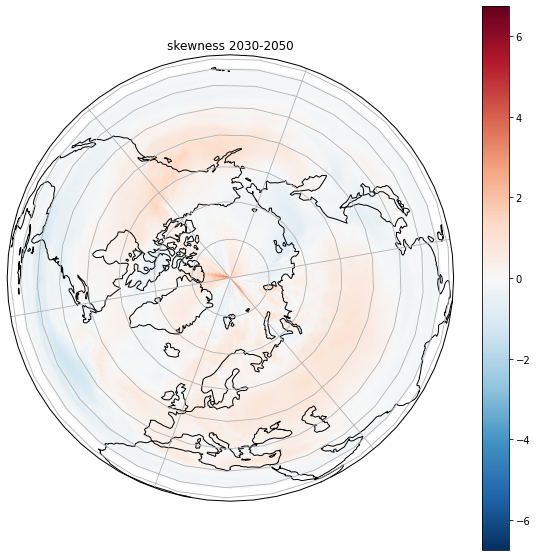

one week!


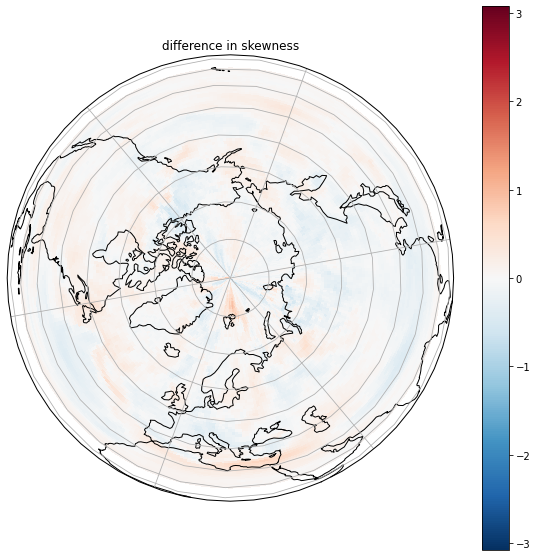

<xarray.DataArray (lat: 75, lon: 288)>
array([[ 0.05568878,  0.10309939,  0.09020255, ...,  0.04403566,
        -0.01779799,  0.00327814],
       [-0.0937857 ,  0.1161669 ,  0.0835977 , ...,  0.05296506,
        -0.0587638 , -0.08560977],
       [-0.04241853, -0.06329372,  0.08829735, ...,  0.00695918,
        -0.01978486, -0.00552459],
       ...,
       [ 0.11336633,  0.09796189,  0.09992992, ...,  0.11006724,
         0.1173431 ,  0.10913157],
       [ 0.11264418,  0.11272182,  0.11602043, ...,  0.13334586,
         0.12664976,  0.11885719],
       [ 0.11703429,  0.11722153,  0.11547091, ...,  0.11010949,
         0.10944252,  0.1145073 ]])
Coordinates:
  * lat      (lat) float64 90.0 89.06 88.12 87.17 ... 23.09 22.15 21.2 20.26
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [57]:
convert_to_xarray(skew_xr.skewness1,plot=True,titlestr='skewness 2015-2030',data_source='CESM')
convert_to_xarray(skew_xr.skewness2,plot=True,titlestr='skewness 2030-2050',data_source='CESM')
convert_to_xarray(skew_xr.skewdiff,plot=True,titlestr='difference in skewness',data_source='CESM')

In [31]:
280*1440

403200

In [24]:
lateff_reanalysis = pd.read_csv('/project2/geos39650/jet_stream/data/model_output/eff_lat/eff_lat_reanalysis_1980_2018.csv')
times = lateff_reanalysis.time.values
convert_to_xarray(lateff_reanalysis[times==times[0]],plot=True)

ValueError: cannot reshape array of size 245 into shape (280,1440)

In [26]:
lateff_reanalysis[times==times[0]]

,temp_bracket,time,area_grid,cdf_eff_lat_mapping,eff_lat_deg
0,208.469,1980-12-01,0.000000e+00,1.570796,90.000000
3429,210.469,1980-12-01,0.000000e+00,1.570796,90.000000
6858,212.469,1980-12-01,0.000000e+00,1.570796,90.000000
10287,214.469,1980-12-01,0.000000e+00,1.570796,90.000000
13716,216.469,1980-12-01,0.000000e+00,1.570796,90.000000
17145,218.469,1980-12-01,1.026517e+04,1.561819,89.485660
20574,220.469,1980-12-01,6.643484e+04,1.547959,88.691490
24003,222.469,1980-12-01,1.654458e+05,1.534754,87.934930
27432,224.469,1980-12-01,3.104693e+05,1.521421,87.170975
30861,226.469,1980-12-01,4.956590e+05,1.508406,86.425270
